### Forecasting Wind Turbine Power Output

#### Week1

##### Data Loading and Cleaning

In [138]:
# import datasets
import pandas as pd

turbine_data = pd.read_csv("WindTurbine_Data.csv")
# # Upload manually in Colab
# uploaded = files.upload()
# file_name = list(uploaded.keys())[0]
# turbine_data = pd.read_csv(file_name)

# keeping focused dataset
turbine_data = turbine_data[['Date/Time','Wind Speed (m/s)','LV ActivePower (kW)','Theoretical_Power_Curve (KWh)','Wind Direction (°)']]
print("Data loaded successfully. Shape:",turbine_data.shape)
turbine_data.head(3)

Data loaded successfully. Shape: (50530, 5)


,Date/Time,Wind Speed (m/s),LV ActivePower (kW),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,5.311336,380.047791,416.328908,259.994904
1,01 01 2018 00:10,5.672167,453.769196,519.917511,268.641113
2,01 01 2018 00:20,5.216037,306.376587,390.900016,272.564789


##### Preprocessing

In [139]:
import numpy as np
# Ensure consistent reproducibility for any random operations
np.random.seed(42)

In [140]:
# Preprocessing

turbine_data.info()

print("Initial dataset shape:", turbine_data.shape)
print("Duplicates found from the dataset: ", turbine_data.duplicated().sum())
# Drop duplicates if any
turbine_data = turbine_data.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   Wind Speed (m/s)               50530 non-null  float64
 2   LV ActivePower (kW)            50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB
Initial dataset shape: (50530, 5)
Duplicates found from the dataset:  0


In [141]:
# Convert Date/Time to datetime
turbine_data['Date/Time'] = pd.to_datetime(turbine_data['Date/Time'], format="%d %m %Y %H:%M")

# Set Date/Time as index
turbine_data = turbine_data.set_index('Date/Time')

# Check missing values
missing_count = turbine_data.isna().sum()
print("Missing Values per Column:\n", missing_count)

# Interpolate missing values using time-based method if any
if missing_count.sum() > 0:
    turbine_data = turbine_data.interpolate(method='time')
    print("Interpolation applied using time-based method.")
else:
    print("No missing values found. Interpolation not required.")


print("Data cleaning completed successfully.")

Missing Values per Column:
 Wind Speed (m/s)                 0
LV ActivePower (kW)              0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64
No missing values found. Interpolation not required.
Data cleaning completed successfully.


##### Feature Engineering

In [142]:
# Physical and directional feature engineering

#  Wind speed cubic relationship (from aerodynamic power law)
turbine_data['Wind_Speed_Cubed'] = turbine_data['Wind Speed (m/s)'] ** 3

# Convert wind direction to sin and cos (handles circular nature of angles)
turbine_data['Dir_Sin'] = np.sin(np.radians(turbine_data['Wind Direction (°)']))
turbine_data['Dir_Cos'] = np.cos(np.radians(turbine_data['Wind Direction (°)']))

# Rolling average of wind speed for short-term stability (1-hour smoothing, 6 samples per hour)
turbine_data['Rolling_Speed'] = turbine_data['Wind Speed (m/s)'].rolling(window=6, min_periods=1).mean()

# Convert theoretical power curve (KWh to kW for consistency)
turbine_data['Theoretical_kW'] = turbine_data['Theoretical_Power_Curve (KWh)']

# Power deficit: theoretical - actual. (how much power is lost due to air density / yaw / mechanical loss / wake effect)
turbine_data['Power_Deficit'] = turbine_data['Theoretical_kW'] - turbine_data['LV ActivePower (kW)']

# Efficiency: actual / theoretical (% output compared to theoretical)
turbine_data['Efficiency (%)'] = (turbine_data['LV ActivePower (kW)'] / turbine_data['Theoretical_kW']) * 100

# Display
print(turbine_data.head())
print("Feature engineering completed. Total columns:", turbine_data.shape[1])

                     Wind Speed (m/s)  LV ActivePower (kW)  \
Date/Time                                                    
2018-01-01 00:00:00          5.311336           380.047791   
2018-01-01 00:10:00          5.672167           453.769196   
2018-01-01 00:20:00          5.216037           306.376587   
2018-01-01 00:30:00          5.659674           419.645904   
2018-01-01 00:40:00          5.577941           380.650696   

                     Theoretical_Power_Curve (KWh)  Wind Direction (°)  \
Date/Time                                                                
2018-01-01 00:00:00                     416.328908          259.994904   
2018-01-01 00:10:00                     519.917511          268.641113   
2018-01-01 00:20:00                     390.900016          272.564789   
2018-01-01 00:30:00                     516.127569          271.258087   
2018-01-01 00:40:00                     491.702972          265.674286   

                     Wind_Speed_Cubed   Dir_Si

#### Week2

##### EDA

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)

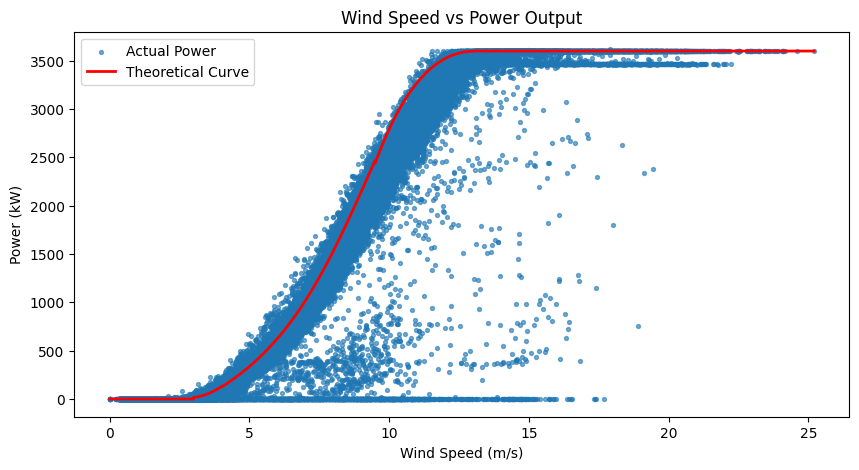

In [144]:
#1. Scatter: Wind Speed vs Actual + Theoretical Curve
sorted_data = turbine_data.sort_values('Wind Speed (m/s)')

plt.figure()
plt.scatter(turbine_data['Wind Speed (m/s)'],
            turbine_data['LV ActivePower (kW)'],
            s=8, alpha=0.6, label="Actual Power")

plt.plot(sorted_data['Wind Speed (m/s)'],
         sorted_data['Theoretical_kW'], color='red',
         linewidth=2, label="Theoretical Curve")

plt.title("Wind Speed vs Power Output")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()

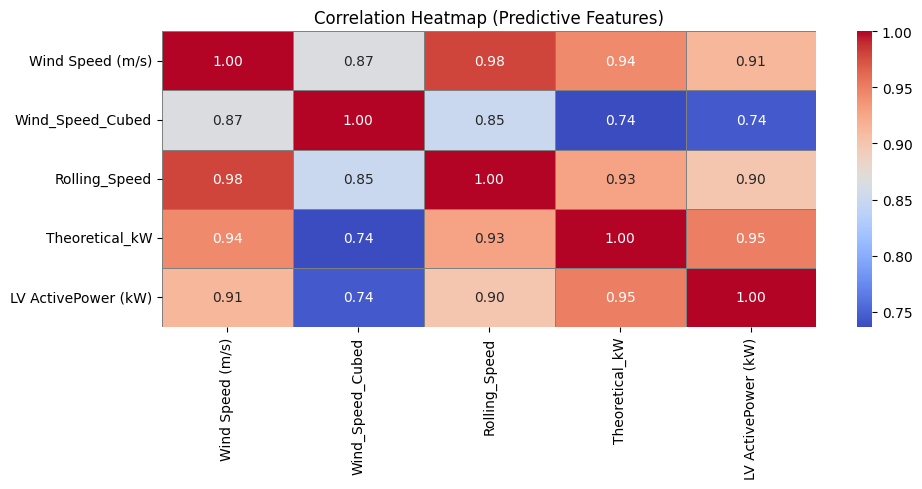

In [145]:
# 2. Correlation Heatmap for key predictive features
features_corr = ['Wind Speed (m/s)', 'Wind_Speed_Cubed',
                 'Rolling_Speed', 'Theoretical_kW', 'LV ActivePower (kW)']

corr = turbine_data[features_corr].corr()

plt.figure()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=0.5, linecolor='gray')
plt.title('Correlation Heatmap (Predictive Features)')
plt.tight_layout()
plt.show()

Average Power (kW) by Wind Zone:
Wind_Zone
Low         50.0
Medium    1082.4
High      3114.2
Name: LV ActivePower (kW), dtype: float64


/tmp/ipython-input-2107475920.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_summary = turbine_data.groupby('Wind_Zone')['LV ActivePower (kW)'].mean().round(1)


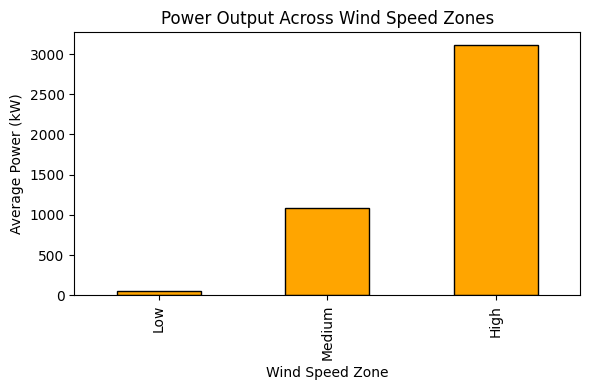

In [146]:
#3. Wind Speed Zones

bins = [-float('inf'), 5, 10, float('inf')]
labels = ['Low', 'Medium', 'High']

turbine_data['Wind_Zone'] = pd.cut(turbine_data['Wind Speed (m/s)'], bins=bins, labels=labels)

zone_summary = turbine_data.groupby('Wind_Zone')['LV ActivePower (kW)'].mean().round(1)
print("Average Power (kW) by Wind Zone:")
print(zone_summary)

zone_summary.plot(kind='bar', color='orange', edgecolor='black', figsize=(6,4))
plt.ylabel("Average Power (kW)")
plt.xlabel("Wind Speed Zone")
plt.title("Power Output Across Wind Speed Zones")
plt.tight_layout()
plt.show()

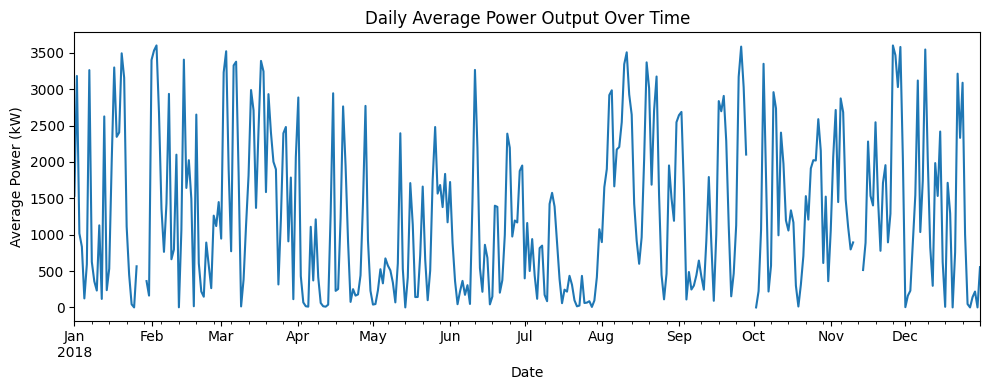

In [147]:
#Adding trend plot for time-based performance overview
plt.figure(figsize=(10,4))
turbine_data['LV ActivePower (kW)'].resample('D').mean().plot()
plt.title('Daily Average Power Output Over Time')
plt.xlabel('Date')
plt.ylabel('Average Power (kW)')
plt.tight_layout()
plt.show()

In [148]:
# Save key plots for documentation or reports
# plt.savefig('wind_speed_zones.png', dpi=300)

##### Model Training

##### train-test split

In [151]:
# import os
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
# os.environ['PYTHONHASHSEED'] = str(SEED)

In [152]:
#Train-Test Split
turbine_data = turbine_data.sort_index()
# ensure turbine_data is the cleaned DataFrame with DateTime index
split_point = int(len(turbine_data) * 0.8)               # We train on first 80% of the year and test on last 20%

train = turbine_data.iloc[:split_point].copy()
test  = turbine_data.iloc[split_point:].copy()

# Features and Target
features = ['Wind Speed (m/s)', 'Wind_Speed_Cubed', 'Dir_Sin', 'Dir_Cos', 'Rolling_Speed']
target = 'LV ActivePower (kW)'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# EXTRA
# ensure numeric dtype consistency for XGBoost
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test  = y_test.astype(np.float32)

print("train shape:", X_train.shape, "test shape:", X_test.shape)

train shape: (40424, 5) test shape: (10106, 5)


##### Linear regression


In [153]:
#Linear Regression (Baseline Model)
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

# train
lr_model.fit(X_train, y_train)

LinearRegression()

In [154]:
# Predictions
lr_pred = lr_model.predict(X_test)
print("Linear Regression training complete.")

Linear Regression training complete.


##### XGBoost Regressor

In [155]:
# XGBoost Model (Non-linear performance model)
from xgboost import XGBRegressor

xgb_model = XGBRegressor(                              # Initialize model
    n_estimators=300,                                           # number of boosting rounds (trees)
    learning_rate=0.08,                                         # how fast the model learns; smaller = slower but safer
    max_depth=6,                                                # how deep each tree can grow
    subsample=0.8,                                              # use 80% of data per tree (helps avoid overfitting)
    colsample_bytree=0.8,                                       # use 80% of features per tree (adds randomness)
    random_state=SEED,                                          # makes results reproducible
    n_jobs=1,                                                   # uses 1 CPU thread → avoids nondeterministic parallel effects
    tree_method='hist',                                         # faster, deterministic way to build trees
    seed=SEED                                                   # another seed parameter (used internally by XGBoost)

)

xgb_model.fit(X_train, y_train)                         # Train model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=1, num_parallel_tree=None, ...)

In [156]:
# Predictions
xgb_pred = xgb_model.predict(X_test)
print("XGBoost model training complete.")

XGBoost model training complete.


##### Evaluation.

In [157]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

results = {}
def evaluate(name, actual, predicted):                                    # Evaluation function
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}                 # TO save them for model
    print(f"\n{name} Model Performance:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.3f}")

evaluate("Linear Regression", y_test, lr_pred)                           # Evaluate both models
evaluate("XGBoost", y_test, xgb_pred)



Linear Regression Model Performance:
MAE  : 724.23
RMSE : 867.08
R²   : 0.583

XGBoost Model Performance:
MAE  : 275.80
RMSE : 594.97
R²   : 0.803


#### Week3

##### The better model

In [158]:
# Selecting better model
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

best_model = xgb_model if xgb_rmse < lr_rmse else lr_model
print("Selected Best Model:", type(best_model).__name__)

Selected Best Model: XGBRegressor


##### SAVE the model

In [160]:
import joblib
import os
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

os.makedirs("models", exist_ok=True)                                                  # Setup folder for saved objects
SEED = 42
np.random.seed(SEED)

print("Selected Best Model:", type(best_model).__name__)                              # selecting the better model.

# Save best model with fixed name for deployment
joblib.dump(best_model, "models/wind_power_model.pkl")
print("Saved best model as: wind_power_model.pkl")

Selected Best Model: XGBRegressor
Saved best model as: wind_power_model.pkl


In [161]:
# saving the preprocessed output and feature
def preprocess_input(df):
    df = df.copy()
    df['Wind_Speed_Cubed'] = df['Wind Speed (m/s)']**3
    df['Dir_Sin'] = np.sin(np.radians(df['Wind Direction (°)']))
    df['Dir_Cos'] = np.cos(np.radians(df['Wind Direction (°)']))
    df['Rolling_Speed'] = df['Wind Speed (m/s)']  # for single-point prediction
    return df[['Wind Speed (m/s)', 'Wind_Speed_Cubed', 'Dir_Sin', 'Dir_Cos', 'Rolling_Speed']]

joblib.dump(preprocess_input, "models/preprocess_input.pkl")
print("Saved preprocessing function.")

# Saving Features
features_list = ['Wind Speed (m/s)', 'Wind_Speed_Cubed', 'Dir_Sin', 'Dir_Cos', 'Rolling_Speed']

# saving performance metrics
metrics = {
    "Linear_Regression": {
        "RMSE": lr_rmse,
        "MAE": mean_absolute_error(y_test, lr_pred),
        "R2": r2_score(y_test, lr_pred)
    },
    "XGBoost": {
        "RMSE": xgb_rmse,
        "MAE": mean_absolute_error(y_test, xgb_pred),
        "R2": r2_score(y_test, xgb_pred)
    }
}

joblib.dump({"features": features_list, "metrics": metrics}, "models/model_metadata.pkl")
print("Model, preprocessing function, features, and metrics saved successfully.")

Saved preprocessing function.
Model, preprocessing function, features, and metrics saved successfully.
